# Distributional and frequency effects in word embeddings: Large corpora
## © 2018 Chris Culy, August 2018
### [chrisculy.net](http://chrisculy.net/)

## Overview

This is one of a [series of posts](dist_freq_more_intro.html) on extending the preceding [posts on frequency effects](dist_freq_intro.html) to more embedding techniques and more corpora. In this post I look at some embeddings based on large corpora, embeddings which have been widely used as sample testbeds. In particular, I will be examining the [Google News embeddings](#ref1), the [GLoVe embeddings](#ref2) and the [FastText English embeddings](#ref3).

### Results and contributions

* **new** Frequency encoding is stronger for the larger corpora than for _Vanity Fair_
* **new** Frequency stratfication tends to be stronger for _Vanity Fair_ than for the larger corpora (except in the case of GLoVe)
* **new** Frequency stratification tends to be direct for the larger corpora and indirect for _Vanity Fair_ (except in the case of GLoVe)
* **new** Powerlaw for nearest neighbors is stronger for the larger corpora than for _Vanity Fair_
* Similarity skewness is moderate

[Download as Jupyter notebook](dist_freq_large_corpora.ipynb)

[Download supplemental Python code](dfewe.zip)

[Download summary test Python code](dfewe_nb.zip)

<input type="checkbox" id="toggleCheck" checked> Show Code

In [1]:
%load_ext autoreload
%autoreload 2

#imports
from dfewe import *
from dfewe_nb.nb_utils import *
from dfewe_nb.freq_tests import run_tests as testfs

In [2]:
#to free up memory
def delete_gn():
    if 'gn_vecs' in globals():
        global gn_vecs, gn_sampler
        del gn_vecs
        del gn_sampler

def delete_glove():
    if 'glove_vecs' in globals():
        global glove_vecs, glove_sampler
        del glove_vecs
        del glove_sampler

def delete_ft():
    if 'ft_vecs' in globals():
        global ft_vecs, ft_sampler
        del ft_vecs
        del ft_sampler


In [3]:
#set up standard corpora + vectors
vfair_all = Setup.make_standard_sampler_and_vecs('vfair',5,100,1) #window=5, dims=100, min_count=1
heartd_all = Setup.make_standard_sampler_and_vecs('heartd',5,100,1) #window=5, dims=100, min_count=1

what = [['Vanity Fair (vfair)'],['Heart of Darkness (heartd)']]
for i,c in enumerate([vfair_all,heartd_all]):
    sampler = c['sampler']
    what[i].extend([sum(sampler.counts.values()), len(sampler.counts)])

show_table(what, headers=['Corpus','Tokens','Types'], title="Corpora sizes")

## Estimating frequencies

Unfortunately for us, pretrained word embeddings do not typically provide detailed information about the frequencies of the items. (In fact, I have not come across any that do.) At best, published information describes the corpus and a bit about how the embeddings were created.

However, we can make a _crude estimate_ of the word frequencies by using a simplified version of Zipf's law, which says that the frequency of the i-th ranked word is roughly proportional to the inverse of the rank.
    
$$freq(i) ≅ \frac{k}{i}$$

While there are lots of issues with Zipf's law, it will have to do for our purposes. The trick is how to calculate *k*, since it varies from one corpus to another. For the rank, it seems like the words in the embedding are ordered by their frequency, so we can get the rank directly from the embedding. We need a frequency estimate for one word in order to calculate *k*. Given the difference between the actual distribution of words and Zipf's law, a medium-high ranked word would work best, but since this approach is so crude, it doesn't matter much. 

For Google News, the description says that the minimum frequency of words included is 5, so we can calculate *k* from a low ranked word, e.g. _RAFFAELE_ (rank = 2,999,996):

$$k_{GN} = i * freq(i) ⇒ k_{GN} = 2,999,996 * 5 ⇒ k_{GN} = 14,999,980$$

For GLoVe and FastText, we'll procede a bit differently since we do not have any frequency information at all about the words included. From the [Google ngram viewer](https://books.google.com/ngrams/), we can get the relative frequency of _dog_ in the year 2000, which is 0.0040587344%. Since the description of GLoVe said they had approximately 6,000,000,000 tokens, the frequency of _dog_ (rank = 2927) in the GLoVe vectors is roughly: 0.0040587344% * 6,000,000,000 = 243,524. So we have:

$$k_G = i * freq(i) ⇒ k_G = 2927 * 243,524 ⇒ k_G = 712,794,748$$

For FastText, with a corpus of 16,000,000,000, we get 0.0040587344% * 16,000,000,000 = 649,398 and so, with rank(_dog_) = 2370:

$$k_{FT} = i * freq(i) ⇒ k_{FT} = 2370 * 649,398 ⇒ k_{FT} = 1,539,073,260$$

Alternatively, since the bulk of the FastText corpus is from Wikipedia, we can use the [first 1B words of Wikipedia](http://mattmahoney.net/dc/enwik9.zip) (helpful instructions [here](https://fasttext.cc/docs/en/unsupervised-tutorial.html)) to estimate the frequency of _dog_. When we do that, we get 800,246. So *k'* (which is used here) is:

$$k_{FT}' = i * freq(i) ⇒ k_{FT}' = 2370 * 800,246 ⇒ k_{FT}' = 1,896,583,020$$


The discrepancy between the estimates shows just how crude they are.


In [4]:
def show_first(vecs, name, n=30):
    show_table([[i,x] for i,x in enumerate(vecs.index2entity[:n])],[],'First %d words from %s' % (n,name))
    
def test_common_words(vecs,name):
    testwds = ['a','an','the','about','from','in','of','to','out','up','very']
    d = []
    for w in testwds:
        if w in vecs.vocab:
            win = 'True'
        else:
            win = '<b>False</b>'            
        d.append([w, win])
        
        w = w.capitalize()
        if w in vecs.vocab:
            win = 'True'
        else:
            win = '<b>False</b>'
        d.append([w, w in vecs.vocab])

    show_table(d,['Word','In %s' % name],'Test of some English words in %s' % name)


def test_non_english_words(vecs,name,topn=5,lowercase=False):
    testwds = ['English','butterfly','cat','dog','the',
               'français','papillon','chat','chien','le',
               'Deutsch','Schmetterling','Katze','Hund','der',
               'italiano','farfalla','gatto','cane','il',
               'español','mariposa','gato','perro','el']
    
    if lowercase:
        testwds = [w.lower() for w in testwds]

    d = []
    for w in testwds:
        if w in vecs.vocab:
            sims = [w, ', '.join([x[0] for x in vecs.similar_by_word(w,topn=topn)])]

        else:
            sims = [w,'N.A.']
        d.append(sims)

    show_table(d,['Word','%d Most similar' % topn],
               'Test of possible non-English words in %s' % name)


## Other issues with pretrained embeddings

There are a variety of other issues with many pretrained embeddings. One issue is that some of them (e.g. Google News and GLoVe) include phrases in addition to words. I have filtered those out here.

Another issue is that there are often some non-word items included, such as punctuation. Here are the top 30 items for FastText. (Information for the other 2 corpora are in the [appendix](#appendix).)

In [5]:
ft_vecs, ft_sampler = Setup.setup_FT_English()

In [6]:
print("Vocabulary: %d\tDimensions: %d" % (len(ft_vecs.vocab), ft_vecs.vector_size))

Vocabulary: 999994	Dimensions: 300


In [7]:
show_first(ft_vecs,'FastText English',30)

The embeddins also differ in terms of whether the items are case sensitive, and even which words are included &mdash; Google News does not include *of* though it does include *Of* (see the [appendix](#appendix). This table shows that FastText is case sensitive.

In [8]:
test_common_words(ft_vecs,'FastText English')

Yet another issue to be aware of is the presence of non-English words. Here we have some results for FastText English, testing synonyms in English, French, German and Italian. There are quite a number of non-English words. (Again, information for the other 2 corpora are in the [appendix](#appendix).)

In [9]:
test_non_english_words(ft_vecs, 'FastText English')

## The properties

Continuing with FastText, we can look for frequency and distributional effects using the summary tests from the [previous post](dist_freq_properties.html). First the test results in the table. Unfortunately, the tests for stratfication of rank and of reciprocity take extremely long for large vocabularies, so I will omit them here.

In [10]:
smplr = ft_sampler
vs = ft_vecs
name = 'FastText'
tests = ['vfreq','sksim','stfreq'] #,'strank','strecip']
testfs(name,smplr,vs,tests=tests)


Testing Vectors ∝ freqs
Testing Vectors ∝ non-v. low freqs
Testing Vectors ∝ non-low freqs
Testing Skewed sims
Testing Stratification of freq


We see strong results for the encoding of frequency in the vectors, but only moderate skewing of similarities and stratification of frequencies. When we compare these results with the results of FastText with _Vanity Fair_, we see that the relative strengths are **reversed**, _as is the direction of stratification_:

In [11]:
smplr = vfair_all['sampler']
vs = vfair_all['ft']
name = 'Vanity Fair with FastText'
tests = ['vfreq','sksim','stfreq'] #,'strank','strecip']
testfs(name,smplr,vs,tests=tests)

Testing Vectors ∝ freqs
Testing Vectors ∝ non-v. low freqs
Testing Vectors ∝ non-low freqs
Testing Skewed sims
Testing Stratification of freq


Next the visualization based tests. Again, the large vocabulary poses challenges, this time for the power law test, so we'll use a stratified (by percentile) sampling of the vocabulary rather than the whole vocabulary.

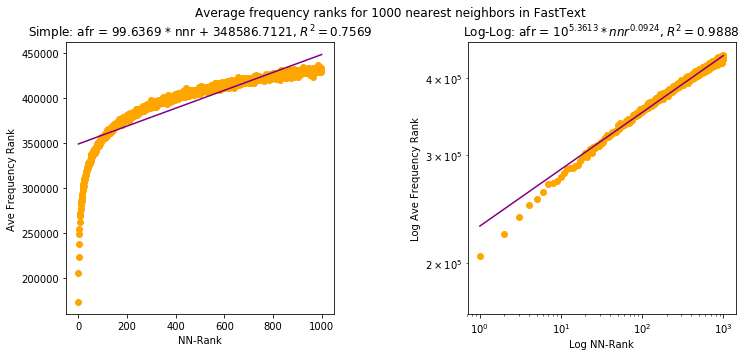

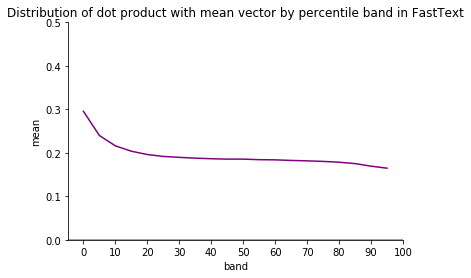

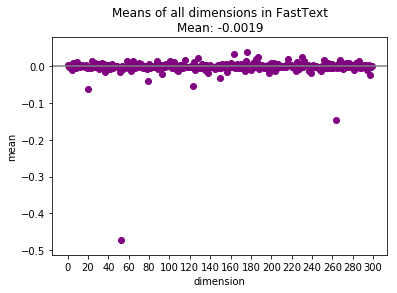

In [12]:
smplr = ft_sampler
vs = ft_vecs
name = 'FastText'
tests = ['vpowers','dpmean','dims']
testfs(name,smplr,vs,tests=tests)


For FastText large scale English vectors, we see a solid powerlaw relation for the k-nearest neighbors, and the dot product trend is the same as that observed in [[4]](#ref4). The most striking result is the dimension values: they are all tightly clustered around 0, unlike any of the other vectors, which show much greater dispersion.

For comparison, we have FastText used with Vanity Fair, where the power law is not particularly evident, and it's an inverse relation, unlike with other vectors.

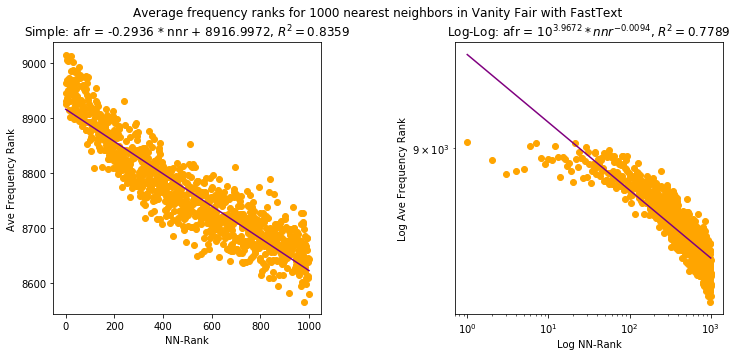

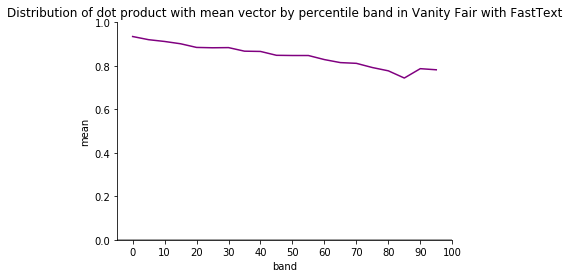

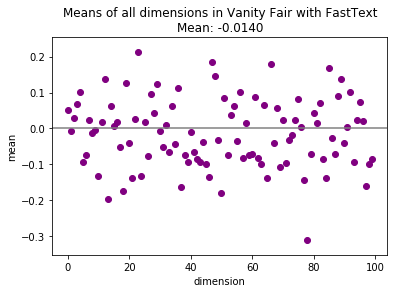

In [13]:
smplr = vfair_all['sampler']
vs = vfair_all['ft']
name = 'Vanity Fair with FastText'
tests = ['vpower','dpmean','dims']
testfs(name,smplr,vs,tests=tests)

The hub tests also take a long time, so I will omit them as well.

In [14]:
#smplr = ft_sampler
#vs = ft_vecs
#name = 'FastText'
#tests = ['hubs','hubp']
#testfs(name,smplr,vs,tests=tests)


In [15]:
delete_ft()

Next up is the Google News, which is a cbow approach. Here the frequency encoding is weak to moderate, as is the stratification of frequencies.

In [16]:
gn_vecs, gn_sampler = Setup.setup_GoogleNews()

In [17]:
print("Vocabulary: %d\tDimensions: %d" % (len(gn_vecs.vocab), gn_vecs.vector_size))

Vocabulary: 3000000	Dimensions: 300


In [18]:
smplr = gn_sampler
vs = gn_vecs
name = 'Google News'
tests = ['vfreq','sksim','stfreq'] #,'strank','strecip']
testfs(name,smplr,vs,tests=tests)


Testing Vectors ∝ freqs
Testing Vectors ∝ non-v. low freqs
Testing Vectors ∝ non-low freqs
Testing Skewed sims
Testing Stratification of freq


Since the Google News vectors were created with cbow version of word2vec, we can compare them to the cbow vectors for _Vanity Fair_. The results are similar, except for the direction of the frequency stratification, which is direct for Google News, but inverse for _Vanity Fair_.

In [19]:
vfair_all['cbow'] = Setup.make_vecs('cbow', vfair_all['sampler'].sents, 1,5,100,init_sims=True) #window=5, dims=100, min_count=1
smplr = vfair_all['sampler']
vs = vfair_all['cbow']
name = 'Vanity Fair with cbow'
tests = ['vfreq','sksim','stfreq'] #,'strank','strecip']
testfs(name,smplr,vs,tests=tests)


Testing Vectors ∝ freqs
Testing Vectors ∝ non-v. low freqs
Testing Vectors ∝ non-low freqs
Testing Skewed sims
Testing Stratification of freq


We can now turn to the visual results, where we see a fairly good powerlaw relation. The dot product trend is also similar to what we saw with sgns.


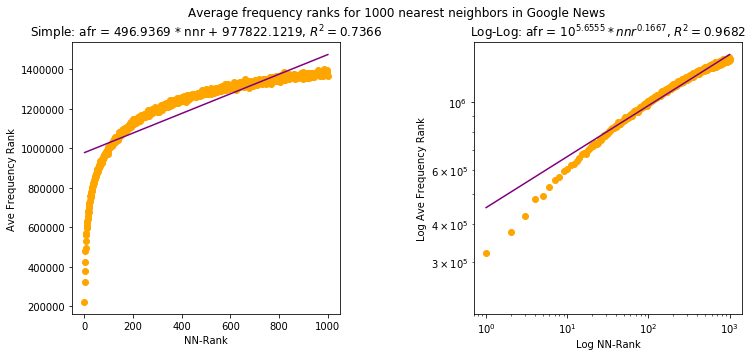

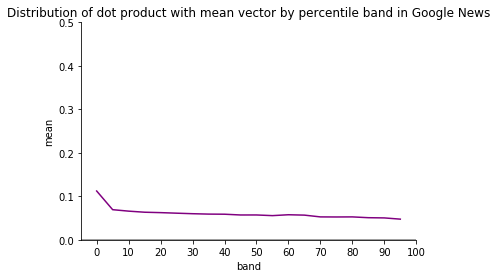

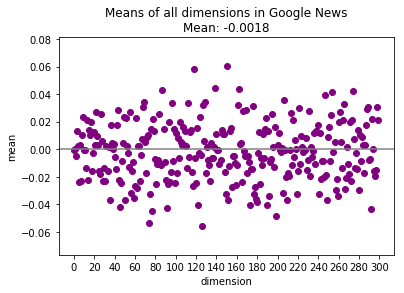

In [20]:
smplr = gn_sampler
vs = gn_vecs
name = 'Google News'
tests = ['vpowers','dpmean','dims']
testfs(name,smplr,vs,tests=tests)


When we compare Google News with _Vanity Fair_, we see that _Vanity Fair_ does not have a great powerlaw relationship, and the dot product trend is not as clear as it is with Google News.

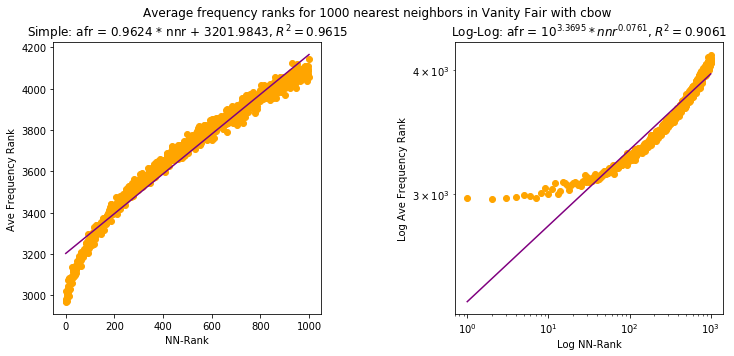

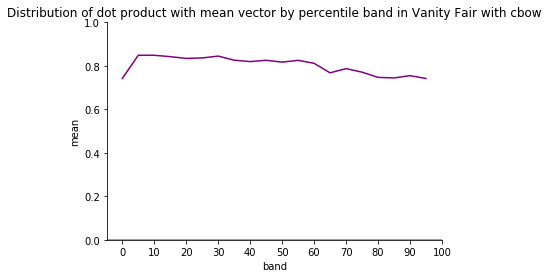

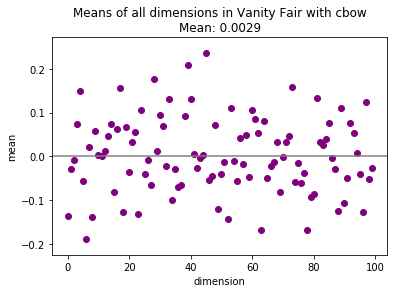

In [21]:
smplr = vfair_all['sampler']
vs = vfair_all['cbow']
name = 'Vanity Fair with cbow'
tests = ['vpower','dpmean','dims']
testfs(name,smplr,vs,tests=tests)

In [22]:
#smplr = gn_sampler
#vs = gn_vecs
#name = 'Google News'
#tests = ['hubs','hubp']
#testfs(name,smplr,vs,tests=tests)


In [23]:
delete_gn()

Finally, we turn to GLoVe. It shows a strong encoding of frequency, but only a moderate skewing of similarities, and a weak, direct, frequency stratification. A similar pattern is seen with GLoVe vectors for _Vanity Fair_ below, though the encoding of frequency is more moderate.

In [24]:
glove_vecs,glove_sampler = Setup.setup_Glove_pre(100)

In [25]:
print("Vocabulary: %d\tDimensions: %d" % (len(glove_vecs.vocab), glove_vecs.vector_size))

Vocabulary: 400000	Dimensions: 100


In [26]:
smplr = glove_sampler
vs = glove_vecs
name = 'GLoVe'
tests = ['vfreq','sksim','stfreq'] #,'strank','strecip']
testfs(name,smplr,vs,tests=tests)


Testing Vectors ∝ freqs
Testing Vectors ∝ non-v. low freqs
Testing Vectors ∝ non-low freqs
Testing Skewed sims
Testing Stratification of freq


In [27]:
smplr = vfair_all['sampler']
vs = vfair_all['glove']
name = 'Vanity Fair with glove'
tests = ['vfreq','sksim','stfreq'] #,'strank','strecip']
testfs(name,smplr,vs,tests=tests)


Testing Vectors ∝ freqs
Testing Vectors ∝ non-v. low freqs
Testing Vectors ∝ non-low freqs
Testing Skewed sims
Testing Stratification of freq


In the last comparison, we have the visual results. The powerlaw is fairly good, and the dot product trend confirms the result in [[4]](#ref4). However, when we look at _Vanity Fair_, the dot product trend is more like what we see with sgns and cbow, not what we see with the large corpus GLoVe vectors.

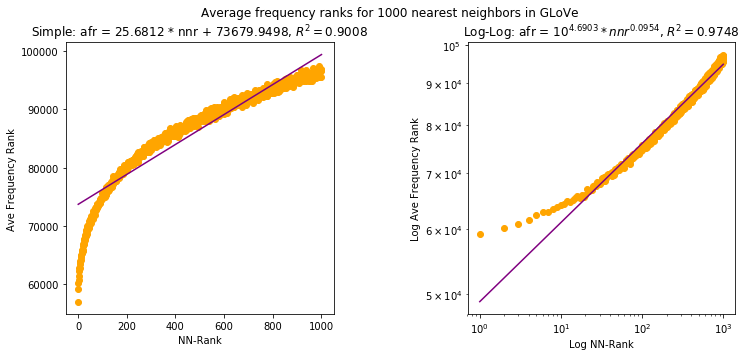

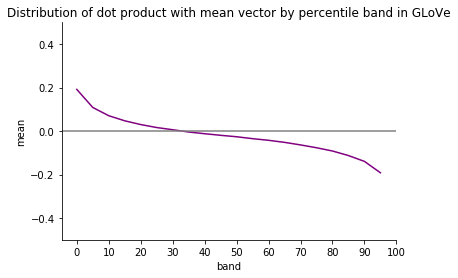

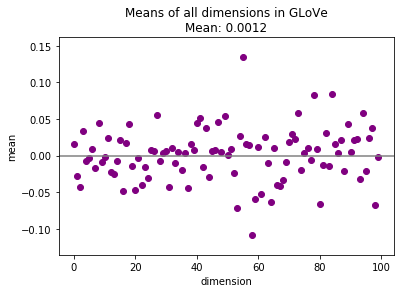

In [28]:
smplr = glove_sampler
vs = glove_vecs
name = 'GLoVe'
tests = ['vpowers','dpmean','dims']
testfs(name,smplr,vs,tests=tests)


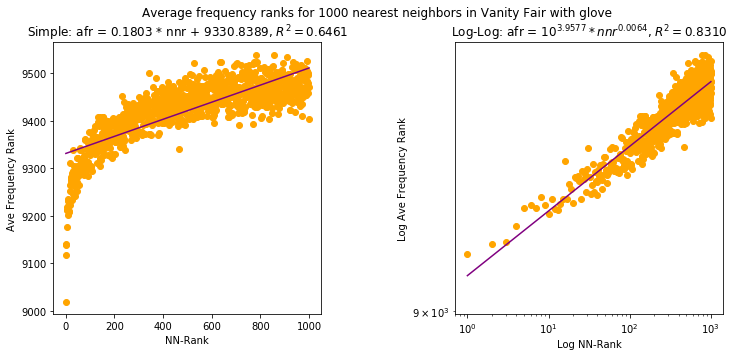

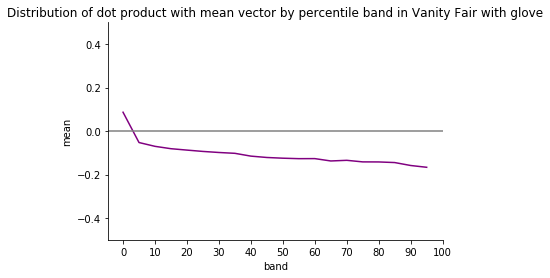

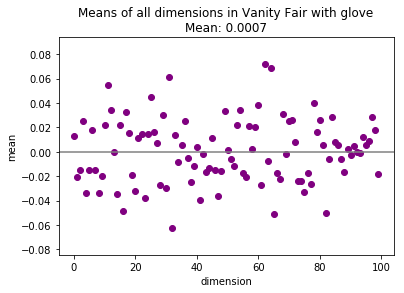

In [29]:
smplr = vfair_all['sampler']
vs = vfair_all['glove']
name = 'Vanity Fair with glove'
tests = ['vpower','dpmean','dims']
testfs(name,smplr,vs,tests=tests)


In [30]:
#smplr = glove_sampler
#vs = glove_vecs
#name = 'GLoVe'
#tests = ['hubs','hubp']
#testfs(name,smplr,vs,tests=tests)


In [31]:
delete_glove()

To sum up, here we have a summary of the summaries:

<table>
    <tr><th></th><th>FastText</th><th></th><th>cbow</th><th></th><th>GLoVe</th></tr>
    <tr><th></th><th>large</th><th>vfair</th><th>large</th><th>vfair</th><th>large</th><th>vfair</th></tr>
    <tr><th>freq encoded</th><td>strong</td><td>moderate</td><td>moderate</td><td>weak+</td><td>strong</td><td>moderate+</td></tr>
    <tr><th>skewed sims</th><td>moderate</td><td>strong</td><td>moderate</td><td>moderate</td><td>moderate</td><td>weak</td></tr>
    <tr><th>freq stratified</th><td>moderate<br>direct</td><td>strong<br>inverse</td><td>moderate<br>direct</td><td>moderate<br>inverse</td><td>weak<br>direct</td><td>moderate<br>direct</td></tr>
    <tr><th>powerlaw</th><td>good</td><td>inverse</td><td>good</td><td>so-so</td><td>good</td><td>so-so</td></tr>
    <tr><th>dot product</th><td>decreasing pos</td><td>decreasing pos</td><td>decreasing pos</td><td>mixed</td><td>decreasing pos to neg</td><td>decreasing pos to neg</td></tr>
</table>    
    
In addition, we saw that FastText English had an unusual distribution of dimension values, clustered tightly around 0.

Some patterns among the summaries:

* Frequency encoding is stronger for the larger corpora than for _Vanity Fair_
* Frequency stratfication tends to be stronger for _Vanity Fair_ than for the larger corpora (except in the case of GLoVe)
* Frequency stratification tends to be direct for the larger corpora and indirect for _Vanity Fair_ (except in the case of GLoVe)
* Powerlaw for nearest neighbors is stronger for the larger corpora than for _Vanity Fair_

Finally, we can note that overall there is only moderate skewing of similarities, although that is what [prompted this investigation](dist_freq_intro.html).




[Back to the introduction](dist_freq_more.html)

## The posts

* [Summary tests](dist_freq_properties.html)
* Large corpora

## References

<span id="ref1">[1]</span> Google News: https://code.google.com/archive/p/word2vec/, published as Tomas Mikolov, Ilya Sutskever, Kai Chen, Gregory S. Corrado, and Jeffrey Dean. 2013. Distributed representations of words and phrases and their composi- tionality. In Advances in Neural Information Processing Systems 26: 27th Annual Conference on Neural Information Processing Systems 2013. Proceedings of a meeting held December 5-8, 2013, Lake Tahoe, Nevada, United States. 3111–3119.

<span id="ref2">[2]</span> Glove: https://nlp.stanford.edu/projects/glove/, pubished as "GloVe: Global Vectors for Word Representation" Jeffrey Pennington, Richard Socher, and Christopher D. Manning. Empirical Methods in Natural Language Processing (EMNLP) 2014. pp. 1532--1543

<span id="ref3">[3]</span> FastText (English): https://fasttext.cc/docs/en/english-vectors.html, published as Tomas Mikolov, Edourd Grave, Piotr Bojanowski, Christian Puhrsch, and Armand Joulin. 2018. Advances in Pre-Training Distributed Word Representations. In Proceedings of the International Conference on Language Resources and Evaluation (LREC 2018).

<span id="ref4">[4]</span> David Mimno and Laure Thompson. 2017. The strange geometry of skip-gram with negative sampling. Proceedings of the 2017 Conference on Empirical Methods in Natural Language Processing, 2873–2878. 



<span id="appendix">&nbsp;</span>
## Appendix


### Information about items in Google News embeddings

In [32]:
gn_vecs, gn_sampler = Setup.setup_GoogleNews()

In [33]:
show_first(gn_vecs,'GoogleNews',30)

In [34]:
test_common_words(gn_vecs,'GoogleNews')

In [35]:
test_non_english_words(gn_vecs,'GoogleNews')

In [36]:
delete_gn()

### Information about items in GLoVe embeddings

In [38]:
glove_vecs,glove_sampler = Setup.setup_Glove_pre(100)

In [39]:
show_first(glove_vecs,'glove',30)

In [40]:
test_common_words(glove_vecs,'Glove')

In [41]:
test_non_english_words(glove_vecs,'Glove', lowercase=True)

In [42]:
delete_glove()